In [289]:

import os
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [290]:
# Define a function to compute binned color features  
class SpatialFeatureExtractor:
    def __init__(self):
        self.size = (16, 16) # Spatial binning dimensions
        
    def extract(self, image):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(image, self.size).ravel() 
        # Return the feature vector
        return features

In [291]:
# Define a function to compute color histogram features  
class HistoFeatureExtractor:
    def __init__(self):
        self.bins = 32
        self.bins_range = (0, 256)
    def extract(self, image):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(image[:,:,0], bins=self.bins, range=self.bins_range)
        channel2_hist = np.histogram(image[:,:,1], bins=self.bins, range=self.bins_range)
        channel3_hist = np.histogram(image[:,:,2], bins=self.bins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

In [292]:
# Define a function to return HOG features and visualization
class HogFeatureExtractor:
    def __init__(self):
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        self.uncacheImage()
        
    def numBlocks(self, blksize):
        return ((blksize // self.pix_per_cell) - self.cell_per_block + 1)
        
    def cacheImage(self, image):
        self.subsample = True
        if self.hog_channel == 'ALL':
            self.sample_hog_features = []
            for channel in range(image.shape[2]):
                self.sample_hog_features.append(self.getHogFeatures(image[:,:,channel], feature_vec=False))
        else:
            self.sample_hog_features = self.getHogFeatures(image[:,:,self.hog_channel], feature_vec=False)
            
    def uncacheImage(self):
        self.subsample = False
        
    def setSubsamplePatch(self, bbox):
        self.subsample_bbox = bbox
        
    def _getHogForSubsample(self, channel=None):
        bbox = self.subsample_bbox
        if self.hog_channel == 'ALL':
            return self.sample_hog_features[channel][bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        else:
            return self.sample_hog_features[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        
    def extract(self, image):
        if self.subsample == True:
            # subsample precalculated hog features
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    hog_features.append(self._getHogForSubsample(channel)) 
                hog_features = np.ravel(hog_features)      
            else:
                hog_features = np.ravel(self._getHogForSubsample())
        else:
            # Call get_hog_features() with vis=False, feature_vec=True
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    hog_features.append(self.getHogFeatures(image[:,:,channel]))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.getHogFeatures(image[:,:,self.hog_channel])
        return hog_features
    
    def getHogFeatures(self, image, vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(image, orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  transform_sqrt=True, 
                                  block_norm='L2-Hys',
                                  visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(image, orientations=self.orient, 
                       pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block, self.cell_per_block), 
                       transform_sqrt=True, 
                       block_norm='L2-Hys',
                       visualise=vis, feature_vector=feature_vec)
            return features

In [293]:
# Define a function to extract features from an image
class ComboFeatureExtractor:
    def __init__(self):
        self.color_space= 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        
        spatial_extractor = SpatialFeatureExtractor()
        spatial_extractor.size = (16, 16) # Spatial binning dimensions
        
        histo_extractor = HistoFeatureExtractor()
        histo_extractor.bins = 32    # Number of histogram bins
        
        hog_extractor = HogFeatureExtractor()
        hog_extractor.orient = 9  # HOG orientations
        hog_extractor.pix_per_cell = 8 # HOG pixels per cell
        hog_extractor.cell_per_block = 2 # HOG cells per block
        hog_extractor.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        
        self.extractors = [spatial_extractor, histo_extractor, hog_extractor]
        
    def _xlateColorSpace(self, image):
        # apply color conversion if other than 'RGB'
        if self.color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif self.color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif self.color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif self.color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = np.copy(image)
            
        return feature_image
        
    def extract(self, image):
        feature_image = self._xlateColorSpace(image)
        
        features = [extractor.extract(feature_image) for extractor in self.extractors]
        return np.concatenate(features)
    
    def setHogFeatureCaching(self, image):
        feature_image = self._xlateColorSpace(image)
        self.extractors[-1].cacheImage(feature_image)
        
    def unsetHogFeatureCaching(self):
        self.extractors[-1].uncacheImage()
        
    def setHogFeaturePatch(self, bbox):
        self.extractors[-1].setSubsamplePatch(bbox)

def extractFeatures(imgfiles, feature_extractor):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgfiles:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        features.append(feature_extractor.extract(image))
    # Return list of feature vectors
    return features

In [294]:
# Train a model with vehicle and no-vehicle images
class Classifier:
    def __init__(self, feature_extractor):
        self.model = None
        self.feature_extractor = feature_extractor
    
    def _listOfAllFilesInDir(self, dir):
        filenames = []
        for root, subdirs, files in os.walk(dir):
            if (len(files) > 0):
                filenames.extend([os.path.join(root, filename) for filename in files])
        return filenames

    def train(self):
        # Read in cars and notcars
        cars = self._listOfAllFilesInDir('vehicles')
        notcars = self._listOfAllFilesInDir('non-vehicles')
        #print(len(cars))
        #image = cv2.imread(cars[0])
        #plt.figure()
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #print(len(nocars))
        #image = cv2.imread(nocars[0])
        #plt.figure()
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Try a smaller subset
        use_subset = False
        if use_subset:
            sample_size = 1000
            cars = cars[0:sample_size]
            notcars = notcars[0:sample_size]

        car_features = extractFeatures(cars, self.feature_extractor)
        notcar_features = extractFeatures(notcars, self.feature_extractor)

        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        test_size = 0.2
        X_cars_train, X_cars_test, y_cars_train, y_cars_test = train_test_split(
            scaled_X[:len(car_features)], y[:len(car_features)], test_size=test_size, random_state=rand_state)
        X_notcars_train, X_notcars_test, y_notcars_train, y_notcars_test = train_test_split(
            scaled_X[len(car_features):], y[len(car_features):], test_size=test_size, random_state=rand_state)
        
        X_train =  np.vstack((X_cars_train, X_notcars_train))
        y_train =  np.hstack((y_cars_train, y_notcars_train))
        
        X_test =  np.vstack((X_cars_test, X_notcars_test))
        y_test =  np.hstack((y_cars_test, y_notcars_test))
        
        # Shuffle data
        
        rand_state = np.random.randint(0, 100)
        X_train, y_train = shuffle(X_train, y_train, random_state=rand_state)
        
        rand_state = np.random.randint(0, 100)
        X_test, y_test = shuffle(X_test, y_test, random_state=rand_state)

        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        self.model = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        self.model.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.model.score(X_test, y_test), 4))
        
    def predict(self, test_image):
        test_features = self.feature_extractor.extract(test_image)
        test_features = self.X_scaler.transform(np.array(test_features).reshape(1, -1))
        prediction = self.model.predict(test_features)
        return prediction

feature_extractor = ComboFeatureExtractor()
classifier = Classifier(feature_extractor)
classifier.train()

Feature vector length: 6156
23.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9868


In [295]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slideWindow(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [296]:
# Define a function to draw bounding boxes
def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [297]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def searchWindows(image, windows, clf):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_image = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Predict using your classifier
        prediction = clf.predict(test_image)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def findCars(image, ystart, ystop, scale, clf):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    img_tosearch = image[ystart:ystop, :]
    if scale != 1:
        imshape = image.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    hog_extractor = feature_extractor.extractors[-1]
    nxblocks = hog_extractor.numBlocks(img_tosearch.shape[1])
    nyblocks = hog_extractor.numBlocks(img_tosearch.shape[0]) 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = hog_extractor.numBlocks(window)
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    feature_extractor.setHogFeatureCaching(img_tosearch)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            bbox = ((xpos, ypos), (xpos+nblocks_per_window, ypos+nblocks_per_window))
            feature_extractor.setHogFeaturePatch(bbox)
            
            xleft = xpos*hog_extractor.pix_per_cell
            ytop = ypos*hog_extractor.pix_per_cell

            # Extract the image patch
            subimage = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Predict
            test_prediction = clf.predict(subimage)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    feature_extractor.unsetHogFeatureCaching()
    
    return on_windows

In [298]:
def addHeat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def applyThreshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def drawLabeledBboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    # Return the image
    return img

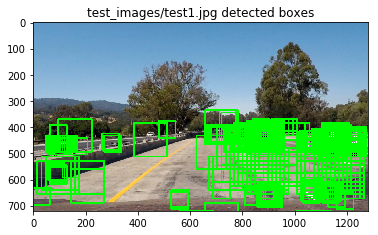

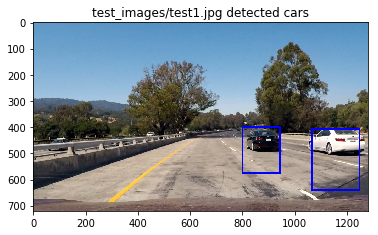

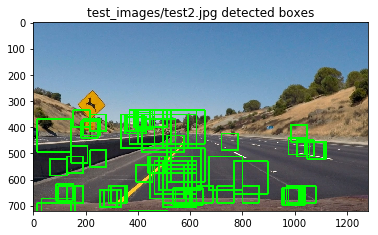

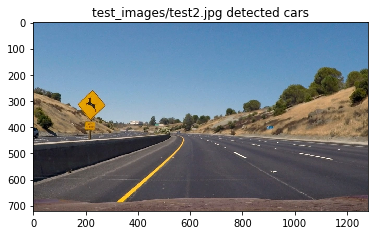

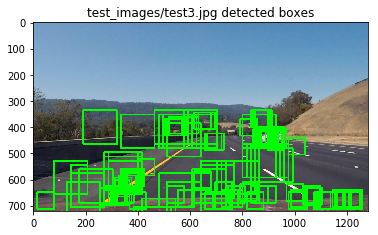

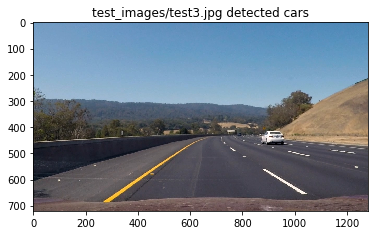

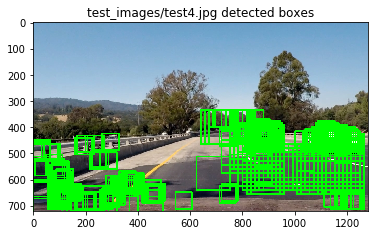

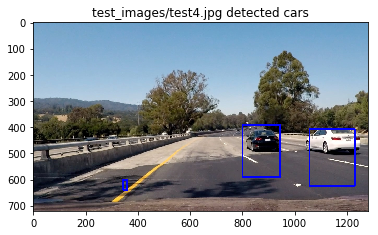

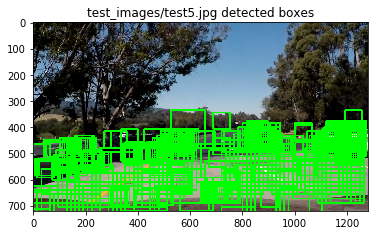

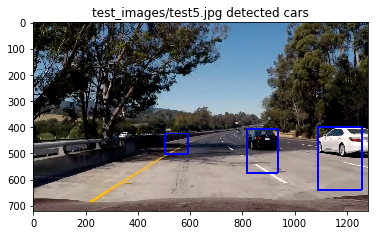

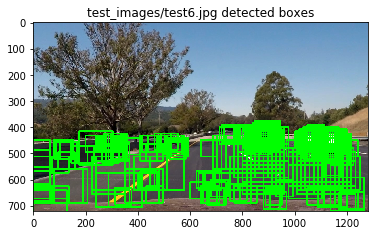

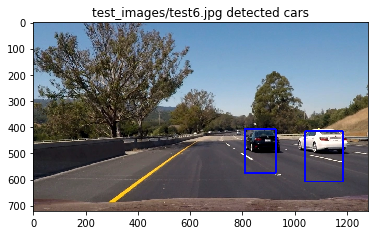

In [299]:
test_images = glob.glob('test_images/*.jpg')
#test_images = glob.glob('test_images/test1.jpg')

y_start_stop=[336, 720]
windows64 = slideWindow(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows128 = slideWindow(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows = windows64 + windows128

for imagefile in test_images:
    image = cv2.imread(imagefile)
    if False:
        hot_windows = searchWindows(image, windows, classifier)  
    else:
        hot_windows = findCars(image, y_start_stop[0], y_start_stop[1], scale=1, clf=classifier)
        hot_windows.extend(findCars(image, y_start_stop[0], y_start_stop[1], scale=2, clf=classifier))
        
    window_image = drawBoxes(image, hot_windows, color=(0, 255, 0), thick=6)  
    
    heat = np.zeros_like(image[:,:,2]).astype(np.float)  

    # Add heat to each box in box list
    heat = addHeat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = applyThreshold(heat, 20)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = drawLabeledBboxes(np.copy(image), labels)

    plt.figure()
    plt.imshow(cv2.cvtColor(window_image, cv2.COLOR_BGR2RGB))
    plt.title(imagefile + ' detected boxes') 
    
    #plt.figure()
    #plt.imshow(heatmap, cmap='hot')
    #plt.title(imagefile + ' Heat Map')
    
    plt.figure()
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.title(imagefile + ' detected cars')